This notebook generates the plot in the top left of Figure 1, which shows three combs placed at different places in an IR spectrum.

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define comb creation functions
def comb_x(cps1):
  comb_x_values = np.fft.fftfreq(n = int(cps1['time'] * cps1['sample_rate']), d = 1 / cps1['sample_rate'])
  return comb_x_values

def calculate_h(cps2, comb_x_values_i):
  path_length = 100e-3
  speed_of_light = 3e8
  refractive_index = cps2['n_0']
  absorption_coefficient = cps2['alpha_0']
  refractive_index_transformed = refractive_index + 0.1 * np.sin(comb_x_values_i*2*np.pi)
  absorption_coeffient_transoformed = absorption_coefficient * np.exp(-comb_x_values_i / 1.5e14)
  H_absorption_value = np.exp(-absorption_coeffient_transoformed * path_length)
  H_phase_value = np.exp(-1j * 2 * np.pi * comb_x_values_i * (refractive_index_transformed - 1) * path_length / speed_of_light)
  H_value = H_absorption_value * H_phase_value
  return H_value

def comb_y(cps3, comb_x_values_j):
  # Identify the basic independent variable points representing the entire wave, known as samples
  number_of_samples = int(cps3['time'] * cps3['sample_rate'])
  sample_set = np.zeros(number_of_samples) # Unit is 'number of samples,' representing total amount of points present in the grand train

  # Addresses pulses in the wave
  number_of_pulses_without_reference_to_samples = int(cps3['time'] * cps3['rep_rate'])
  amount_of_samples_coincident_with_pulses = int(cps3['pulse_duration'] * cps3['sample_rate']) # in just one pulse

  # Identify the time points (with units of seconds, not to be confused with sample points) at which pulses start
  pulse_drift_black_box = np.linspace(0,
                                      cps3['drift'] / cps3['rep_rate'],
                                      number_of_pulses_without_reference_to_samples) * np.exp(np.linspace(0,
                                                                                                          100 * cps3['drift'],
                                                                                                          number_of_pulses_without_reference_to_samples))
  pulse_times_noise_black_box = np.random.normal(loc = np.arange(number_of_pulses_without_reference_to_samples) / cps3['rep_rate'],
                                                 scale = cps3['jitter'] / cps3['rep_rate'],
                                                 size = number_of_pulses_without_reference_to_samples)

  # Synthesize to determine pulse time start points
  actual_pulse_time_start_points = np.add(pulse_times_noise_black_box,
                                          pulse_drift_black_box)

  # Wherever sample points are coincident with pulse points, set those sample values to one
  for actual_pulse_time_start_point in actual_pulse_time_start_points:
    starting_sample = int(actual_pulse_time_start_point * cps3['sample_rate'])
    if starting_sample + amount_of_samples_coincident_with_pulses < number_of_samples:
      sample_set[starting_sample:starting_sample + amount_of_samples_coincident_with_pulses] = 1

  # Add noise to all points of the sample train
  sample_set += cps3['noise'] * np.random.normal(size = number_of_samples)

  # Perform Fourier transform on the sample train to identify ampltidues of constituent frequencies
  fourier_amplitudes = np.fft.fft(sample_set)

  # Modify spectrum according to H parameter
  h_parameter = calculate_h(cps3, comb_x_values_j)
  final_amplitudes = fourier_amplitudes * h_parameter
  return np.abs(final_amplitudes)

def find_center(start_freq, first_harmon_width0):
  center = start_freq + (0.5 * first_harmon_width0)
  return center

def trim_data(final_x_axis0, final_y_axis0, horizontal_comb_shift0, width_of_each_comb0):
  lower_bound_first_harmonic = horizontal_comb_shift0 - (0.5 * width_of_each_comb0)
  upper_bound_first_harmonic = horizontal_comb_shift0 + (0.5 * width_of_each_comb0)

  new_x_axis = []
  new_y_axis = []

  for individual in range(len(final_x_axis0)):
    if final_x_axis0[individual] >= lower_bound_first_harmonic and final_x_axis0[individual] < upper_bound_first_harmonic:
      new_x_axis.append(final_x_axis0[individual])
      new_y_axis.append(final_y_axis0[individual])

  grand_update = []
  grand_update.append(new_x_axis)
  grand_update.append(new_y_axis)
  return grand_update

In [ ]:
# Add all input
ir_spectrum_unprocessed = np.load('/content/10_IR_Spectra_date_7_5.npy')
input_ir_x_axis = ir_spectrum_unprocessed[0]
input_ir_y_axis = ir_spectrum_unprocessed[1]
teeth_spacing = 1
width_of_each_comb = 20
start_frequency_arrays = [1290, 1690, 2990]

In [ ]:
# Generate all data
progress = 0
frequencies = input_ir_x_axis
transmittance_values = input_ir_y_axis / (np.max(input_ir_y_axis)) # Normalize

for guide in range(len(start_frequency_arrays)):
  # Main parameters
  peak_spacing = teeth_spacing
  wavenumber_broadness = 3 * width_of_each_comb
  horizontal_comb_shift = find_center(start_frequency_arrays[guide], width_of_each_comb)
  noise_of_pulse = 0.00

  # Other parameters
  drift_comb = 0.000                  # Jack set this parameter to 0.010
  jitter_comb = 0.000
  refractive_index_comb = 000.0
  absorption_coefficient_comb = 0.0
  total_experiment_duration = 1e3


  # Apply parameters
  broadness_of_comb = wavenumber_broadness / 100
  comb_parameters = {'rep_rate': peak_spacing,
                    'pulse_duration': 60e-3 * (1 / broadness_of_comb),
                    'time': total_experiment_duration,
                    'sample_rate': 100e0 * broadness_of_comb,
                    'noise': noise_of_pulse,
                    'jitter': jitter_comb,
                    'drift': drift_comb,
                    'n_0': refractive_index_comb,
                    'alpha_0': absorption_coefficient_comb}

  # Pass input through comb creation functions defined above
  comb_x_axis = comb_x(comb_parameters)
  comb_y_axis = comb_y(comb_parameters, comb_x_axis)
  final_x_axis = comb_x_axis + horizontal_comb_shift
  final_y_axis = comb_y_axis / (np.max(comb_y_axis))

  new_values = trim_data(final_x_axis, final_y_axis, find_center(start_frequency_arrays[guide], width_of_each_comb), width_of_each_comb)

  # Interpolate IR spectra values and simulate interaction with comb
  ir_spectrum_interpolated_values = np.interp(x = new_values[0], xp = frequencies, fp = transmittance_values)
  exiting_comb = ir_spectrum_interpolated_values * new_values[1]

  if guide == 0:
    column_names = []
    for ex in range(len(new_values[0])):
      name = f'comb_point_{ex}'
      column_names.append(name)
    export = pd.DataFrame(columns = column_names)

  sorted_indices = np.argsort(new_values[0])

  updated_x = []
  updated_y = []
  for finality in sorted_indices:
    updated_x.append(new_values[0][finality])
    updated_y.append(exiting_comb[finality])

  export.loc[progress] = updated_x
  progress = progress + 1
  export.loc[progress] = updated_y
  progress = progress + 1

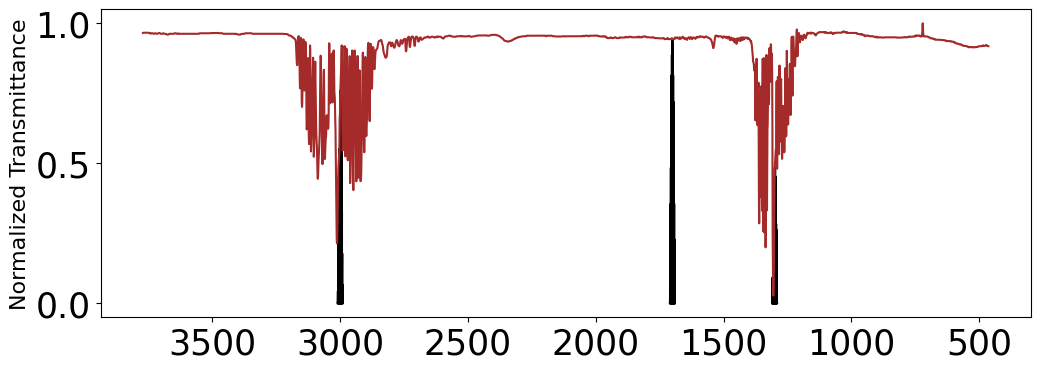

In [ ]:
# Plot figure
figure = plt.figure(figsize = (12, 4))
axes = figure.add_subplot(1, 1, 1)
axes.set_ylabel("Normalized Transmittance", fontsize = 16)
axes.tick_params(labelsize = 25)
axes.invert_xaxis()

axes.plot(export.iloc[0].to_list(), export.iloc[1].to_list(), color = 'black')
axes.plot(export.iloc[2].to_list(), export.iloc[3].to_list(), color = 'black')
axes.plot(export.iloc[4].to_list(), export.iloc[5].to_list(), color = 'black')
axes.plot(ir_spectrum_unprocessed[0], ((ir_spectrum_unprocessed[1])/(np.max(ir_spectrum_unprocessed[1]))), color = 'brown')